In [5]:
import pandas as pd
df = pd.read_csv('lemonrice_with_phone.csv')

In [3]:
df.head()

,timestamp,session_id,src_ip,src_port,dst_ip,dst_port,protocol,duration_sec,bytes,cell_tower_lat,cell_tower_lon,anomalystatus,Phone Number A,Phone Number B
0,2025-10-26T11:44:00Z,8b68955f-2e73-4785-8a95-2f574008b1de,115.96.187.198,26914.0,115.96.225.98,4390.0,SIP,7816.0,749499527.0,28.6139,77.2090,1.0,7806964299,7616051499
1,2025-10-02T12:14:00Z,7a12608b-8d68-4e73-94eb-41ce1d54d130,47.8.167.247,31812.0,47.8.203.46,60152.0,SIP,18640.0,836342793.0,19.0760,72.8777,1.0,8187667228,9744503964
2,2025-08-25T23:41:00Z,1adfc030-ec01-493b-9cb9-59b50211e8f1,117.194.115.59,21202.0,106.51.62.205,2853.0,SIP,10587.0,367988469.0,17.3850,78.4867,1.0,9988846648,8573932561
3,2025-09-27T03:55:00Z,e6b71049-c34f-42b0-860d-e2cb80dfad17,115.96.7.230,9378.0,106.51.108.193,44502.0,TCP,5435.0,706613945.0,12.9716,77.5946,1.0,9141894718,9273452574
4,2025-09-22T00:54:00Z,50675891-4a06-43e8-8c6b-a0bc190eff74,47.8.76.48,45375.0,47.8.57.166,28023.0,HTTPS,11703.0,37690316.0,13.0827,80.2707,1.0,9995415428,9778019931


In [10]:
import pandas as pd
import numpy as np
from datetime import datetime

# Convert timestamp to datetime and extract hour
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.dropna(subset=['timestamp'])  # Drop rows with NaT in timestamp
df['hour_of_day'] = df['timestamp'].dt.hour

# Flag long durations and high bytes
duration_threshold = df['duration_sec'].quantile(0.99)
bytes_threshold = df['bytes'].quantile(0.99)
df['is_long_duration'] = (df['duration_sec'] > duration_threshold).astype(int)
df['is_high_bytes'] = (df['bytes'] > bytes_threshold).astype(int)

# Flag unusual protocols
common_protocols = ['HTTP', 'HTTPS']
df['unusual_protocol'] = (~df['protocol'].isin(common_protocols)).astype(int)

# Flag night time (23:00 to 6:00)
df['is_night_time'] = df['hour_of_day'].apply(lambda x: 1 if (x >= 23 or x <= 6) else 0)

# Calculate bytes per second
df['bytes_per_second'] = df['bytes'] / df['duration_sec']

# Session frequency per phone (example for Phone Number A, using 24h window)
df = df.sort_values(['Phone Number A', 'timestamp'])
def rolling_count_24h(group):
    return group.rolling('1D', on='timestamp').count()['timestamp']
df['session_frequency_per_phone'] = df.groupby('Phone Number A', group_keys=False).apply(rolling_count_24h).reset_index(level=0, drop=True)
df['session_frequency_per_phone'] = df['session_frequency_per_phone'].fillna(1)

C:\Users\Nithi\AppData\Local\Temp\ipykernel_37780\1363552933.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['session_frequency_per_phone'] = df.groupby('Phone Number A', group_keys=False).apply(rolling_count_24h).reset_index(level=0, drop=True)


In [11]:
df['bytes_per_second'] = np.where(df['duration_sec'] > 0,
                                 df['bytes'] / df['duration_sec'],
                                 0)


In [13]:
df['is_night_time'] = df['hour_of_day'].between(0, 6, inclusive='left') | (df['hour_of_day'] == 23)


In [15]:
# Correct session frequency per phone (24h window) using a custom approach
from tqdm import tqdm
df = df.sort_values(['Phone Number A', 'timestamp'])
df['session_frequency_per_phone'] = 1  # Default value
for phone in tqdm(df['Phone Number A'].unique(), desc='Calculating session frequency'):
    phone_df = df[df['Phone Number A'] == phone]
    timestamps = phone_df['timestamp']
    freq = []
    for t in timestamps:
        count = phone_df[(phone_df['timestamp'] >= t - pd.Timedelta('1D')) & (phone_df['timestamp'] <= t)].shape[0]
        freq.append(count)
    df.loc[phone_df.index, 'session_frequency_per_phone'] = freq

Calculating session frequency: 100%|██████████| 1067/1067 [00:01<00:00, 687.93it/s]


In [18]:
from geopy.distance import geodesic

median_locs = df.groupby('Phone Number A')[['cell_tower_lat', 'cell_tower_lon']].median()
df = df.merge(median_locs, on='Phone Number A', suffixes=('', '_median'))
df['geographic_distance'] = df.apply(
    lambda row: geodesic(
        (row['cell_tower_lat'], row['cell_tower_lon']),
        (row['cell_tower_lat_median'], row['cell_tower_lon_median'])
    ).km,
    axis=1
)


In [17]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [19]:
common_ports = [22, 80, 443, 3389, 21, 25, 53, 110, 143, 465, 587, 993, 995]
df['is_common_port'] = df['dst_port'].isin(common_ports).astype(int)
df['is_suspicious_port'] = (~df['dst_port'].isin(common_ports)).astype(int)


In [20]:
from sklearn.model_selection import train_test_split

X = df[['is_long_duration', 'is_high_bytes', 'unusual_protocol', 'is_night_time',
        'bytes_per_second', 'session_frequency_per_phone', 'geographic_distance',
        'is_suspicious_port', 'duration_sec', 'bytes']]
y = df['anomalystatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    class_weights=[1, 2],  # Emphasize anomalies
    eval_metric='Recall',
    iterations=500,
    depth=6,
    learning_rate=0.05,
    verbose=100
)
model.fit(X_train, y_train)


0:	learn: 0.8891967	total: 177ms	remaining: 1m 28s
100:	learn: 0.9058172	total: 353ms	remaining: 1.39s
200:	learn: 0.9445983	total: 555ms	remaining: 826ms
300:	learn: 0.9709141	total: 729ms	remaining: 482ms
200:	learn: 0.9445983	total: 555ms	remaining: 826ms
300:	learn: 0.9709141	total: 729ms	remaining: 482ms
400:	learn: 0.9903047	total: 902ms	remaining: 223ms
499:	learn: 0.9958449	total: 1.07s	remaining: 0us
400:	learn: 0.9903047	total: 902ms	remaining: 223ms
499:	learn: 0.9958449	total: 1.07s	remaining: 0us


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       182
         1.0       0.78      0.88      0.83       178

    accuracy                           0.82       360
   macro avg       0.82      0.82      0.82       360
weighted avg       0.82      0.82      0.82       360

[[138  44]
 [ 21 157]]


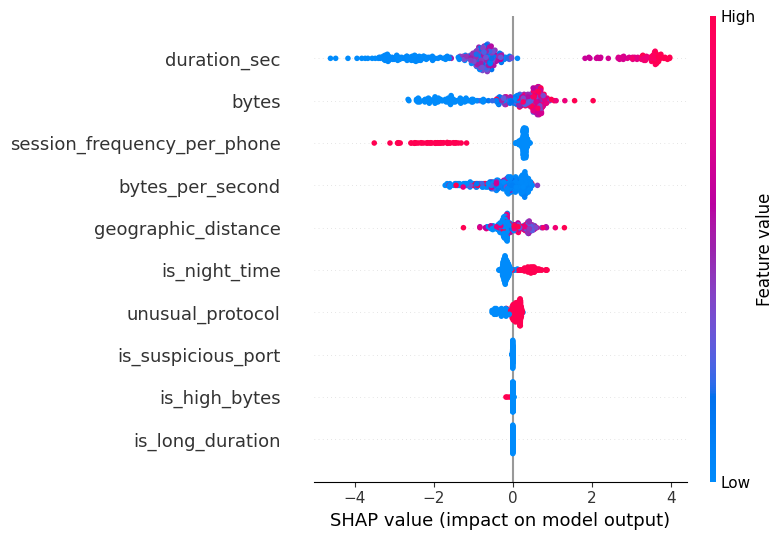

In [25]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [24]:
pip install shap

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


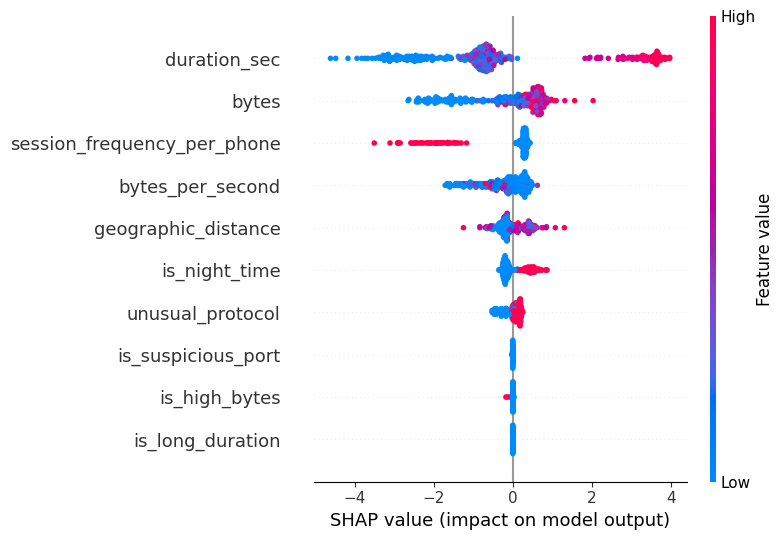

In [26]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


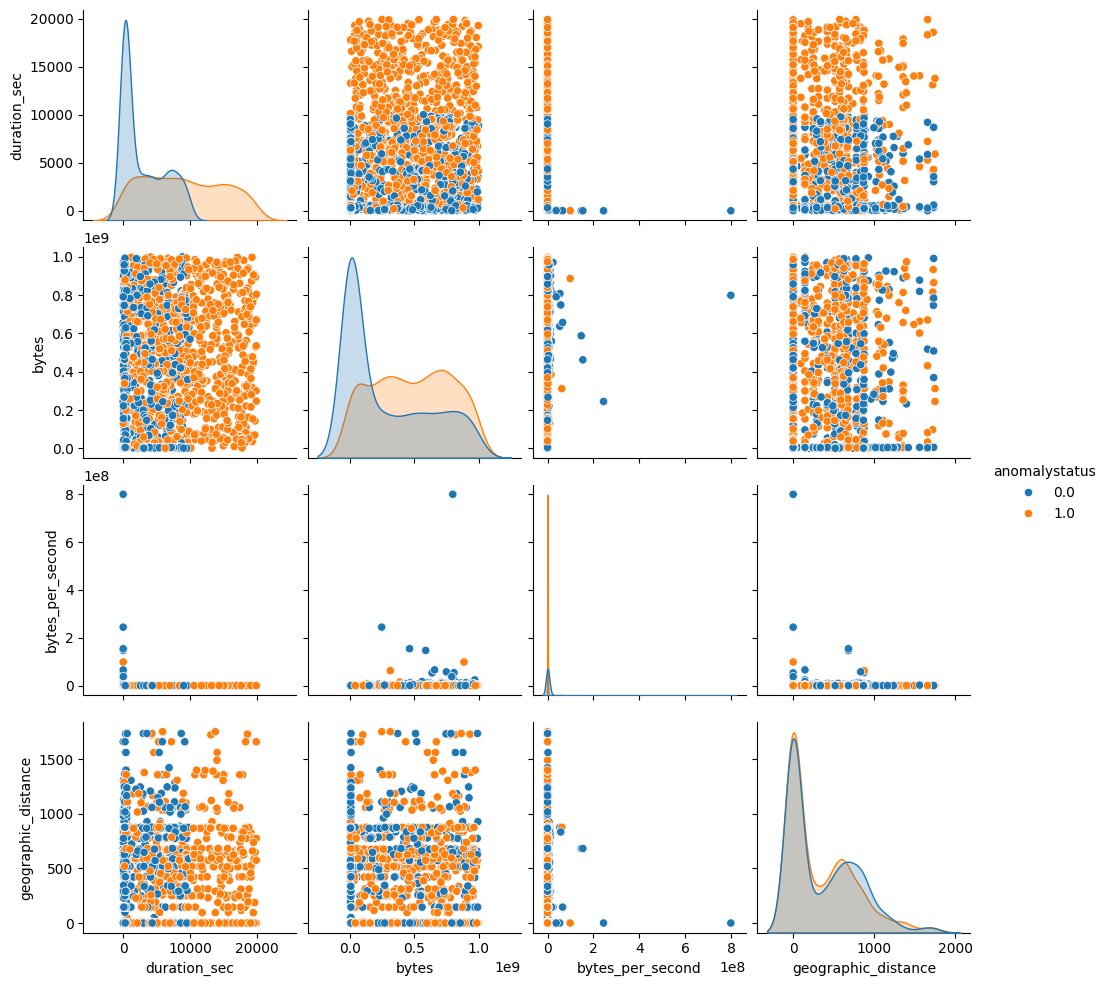

In [27]:
import seaborn as sns
sns.pairplot(df, vars=['duration_sec', 'bytes', 'bytes_per_second', 'geographic_distance'], hue='anomalystatus')


In [28]:
df['duration_times_bytes'] = df['duration_sec'] * df['bytes']
df['is_extreme_bytes_per_second'] = (
    (df['bytes_per_second'] > df['bytes_per_second'].quantile(0.99)) |
    (df['bytes_per_second'] < df['bytes_per_second'].quantile(0.01))
).astype(int)


In [29]:
bins = [0, 100, 500, 1000, 5000]
labels = ['local', 'regional', 'distant', 'very_distant']
df['geographic_distance_bin'] = pd.cut(df['geographic_distance'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['geographic_distance_bin'])


In [30]:
features = [
    'is_long_duration', 'is_high_bytes', 'unusual_protocol', 'is_night_time',
    'bytes_per_second', 'session_frequency_per_phone', 'geographic_distance',
    'is_suspicious_port', 'duration_times_bytes', 'is_extreme_bytes_per_second',
    'geographic_distance_bin_local', 'geographic_distance_bin_regional',
    'geographic_distance_bin_distant', 'geographic_distance_bin_very_distant'
]
X = df[features]
y = df['anomalystatus']

model = CatBoostClassifier(
    class_weights=[1, 2],
    eval_metric='Recall',
    iterations=500,
    depth=6,
    learning_rate=0.05,
    verbose=100
)
model.fit(X, y)


0:	learn: 0.8855556	total: 46.2ms	remaining: 23.1s
100:	learn: 0.8955556	total: 254ms	remaining: 1s
200:	learn: 0.9300000	total: 436ms	remaining: 649ms
100:	learn: 0.8955556	total: 254ms	remaining: 1s
200:	learn: 0.9300000	total: 436ms	remaining: 649ms
300:	learn: 0.9566667	total: 637ms	remaining: 421ms
300:	learn: 0.9566667	total: 637ms	remaining: 421ms
400:	learn: 0.9677778	total: 865ms	remaining: 214ms
499:	learn: 0.9811111	total: 1.05s	remaining: 0us
400:	learn: 0.9677778	total: 865ms	remaining: 214ms
499:	learn: 0.9811111	total: 1.05s	remaining: 0us


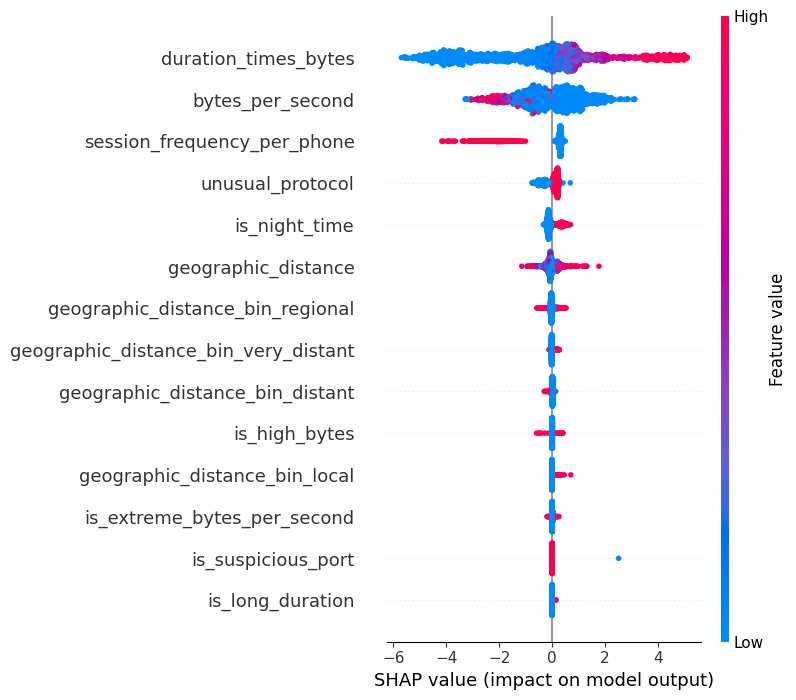

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [32]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


[[756 144]
 [ 17 883]]
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90       900
         1.0       0.86      0.98      0.92       900

    accuracy                           0.91      1800
   macro avg       0.92      0.91      0.91      1800
weighted avg       0.92      0.91      0.91      1800



In [34]:
# Ensure all features used in training are present in X_test
X_test['duration_times_bytes'] = X_test['duration_sec'] * X_test['bytes']
if 'is_extreme_bytes_per_second' in X.columns and 'is_extreme_bytes_per_second' not in X_test.columns:
    X_test['is_extreme_bytes_per_second'] = ((X_test['bytes_per_second'] > X_test['bytes_per_second'].quantile(0.99)) | (X_test['bytes_per_second'] < X_test['bytes_per_second'].quantile(0.01))).astype(int)
# Add any other missing features as needed, with default value 0
for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X.columns]  # Ensure column order matches training
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.6).astype(int)  # Increase threshold from 0.5 to 0.6

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       182
         1.0       0.87      0.94      0.90       178

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360



In [36]:
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))


Confusion Matrix:
 [[156  26]
 [ 11 167]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       182
         1.0       0.87      0.94      0.90       178

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360



In [37]:
y_pred_original = model.predict(X_test)
print("Original Threshold Report:\n", classification_report(y_test, y_pred_original))
print("Adjusted Threshold Report:\n", classification_report(y_test, y_pred_adjusted))


Original Threshold Report:
               precision    recall  f1-score   support

         0.0       0.95      0.80      0.87       182
         1.0       0.83      0.96      0.89       178

    accuracy                           0.88       360
   macro avg       0.89      0.88      0.88       360
weighted avg       0.89      0.88      0.88       360

Adjusted Threshold Report:
               precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       182
         1.0       0.87      0.94      0.90       178

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360



In [38]:
false_positives = X_test[(y_test == 0) & (y_pred_adjusted == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred_adjusted == 0)]

print("False Positives:\n", false_positives[['duration_times_bytes', 'bytes_per_second', 'geographic_distance']].describe())
print("False Negatives:\n", false_negatives[['duration_times_bytes', 'bytes_per_second', 'geographic_distance']].describe())


False Positives:
        duration_times_bytes  bytes_per_second  geographic_distance
count          2.600000e+01      2.600000e+01            26.000000
mean           3.056847e+12      2.254609e+05           305.930858
std            2.281677e+12      6.973777e+05           302.311173
min            1.137639e+11      1.002311e+04             0.000000
25%            1.047648e+12      4.294009e+04             0.000000
50%            2.613181e+12      7.576661e+04           365.401501
75%            4.852425e+12      1.203629e+05           554.710595
max            7.026660e+12      3.622509e+06           873.992088
False Negatives:
        duration_times_bytes  bytes_per_second  geographic_distance
count          1.100000e+01      1.100000e+01            11.000000
mean           5.845654e+10      7.535106e+05           271.287791
std            8.615818e+10      1.526846e+06           268.790702
min            3.186106e+08      2.465808e+02             0.000000
25%            4.155518e+0

In [39]:
# Refine features based on false positive/negative analysis
df['high_duration_times_bytes'] = (df['duration_times_bytes'] > 5e12).astype(int)
df['extreme_bytes_per_second'] = (df['bytes_per_second'] > df['bytes_per_second'].quantile(0.995)).astype(int)
df['short_intense_session'] = ((df['bytes_per_second'] > 1e6) & (df['duration_sec'] < 300)).astype(int)

# Composite feature: Flag only if both duration_times_bytes and geographic_distance are high
df['composite_anomaly_score'] = (
    df['high_duration_times_bytes'] *
    (df['geographic_distance'] > 500)
).astype(int)


In [40]:
# Update features list
features = [
    'duration_times_bytes', 'bytes_per_second', 'geographic_distance',
    'high_duration_times_bytes', 'extreme_bytes_per_second',
    'short_intense_session', 'composite_anomaly_score',
    'is_night_time', 'unusual_protocol', 'session_frequency_per_phone'
]

X = df[features]
y = df['anomalystatus']

# Retrain the model
model = CatBoostClassifier(
    class_weights=[1, 2],  # Emphasize anomalies
    eval_metric='Recall',
    iterations=500,
    depth=6,
    learning_rate=0.05,
    verbose=100
)
model.fit(X, y)

# Evaluate
y_pred = model.predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


0:	learn: 0.8533333	total: 32ms	remaining: 16s
100:	learn: 0.8933333	total: 237ms	remaining: 935ms
100:	learn: 0.8933333	total: 237ms	remaining: 935ms
200:	learn: 0.9266667	total: 445ms	remaining: 662ms
200:	learn: 0.9266667	total: 445ms	remaining: 662ms
300:	learn: 0.9566667	total: 678ms	remaining: 449ms
300:	learn: 0.9566667	total: 678ms	remaining: 449ms
400:	learn: 0.9733333	total: 894ms	remaining: 221ms
400:	learn: 0.9733333	total: 894ms	remaining: 221ms
499:	learn: 0.9833333	total: 1.1s	remaining: 0us
499:	learn: 0.9833333	total: 1.1s	remaining: 0us
[[762 138]
 [ 15 885]]
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91       900
         1.0       0.87      0.98      0.92       900

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.91      1800
weighted avg       0.92      0.92      0.91      1800

[[762 138]
 [ 15 885]]
              precision    recall  f1-score   support

         0.

In [41]:
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.6).astype(int)  # Start with 0.6 and adjust
print(confusion_matrix(y, y_pred_adjusted))
print(classification_report(y, y_pred_adjusted))


[[801  99]
 [ 33 867]]
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92       900
         1.0       0.90      0.96      0.93       900

    accuracy                           0.93      1800
   macro avg       0.93      0.93      0.93      1800
weighted avg       0.93      0.93      0.93      1800



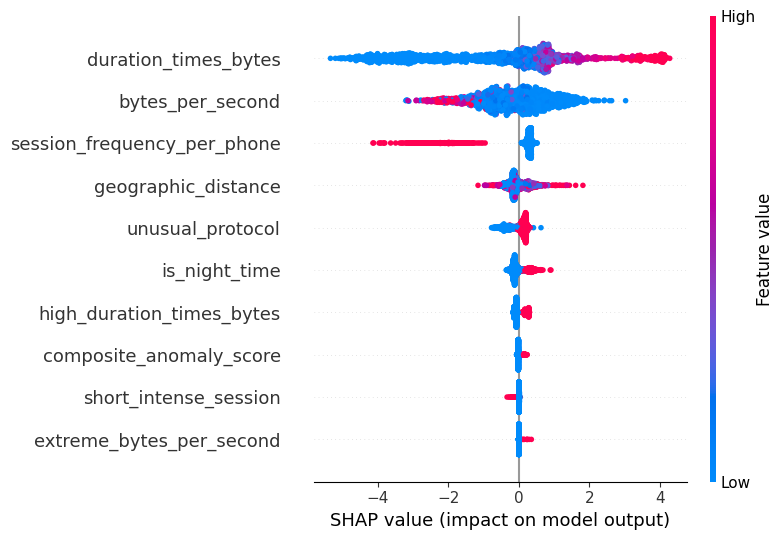

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [43]:
df['short_intense_session'] = (
    (df['bytes_per_second'] > 5e5) &  # Lower threshold from 1e6
    (df['duration_sec'] < 300)
).astype(int)


In [44]:
false_positives = X[(y == 0) & (y_pred == 1)]
print(false_positives[['duration_times_bytes', 'bytes_per_second', 'geographic_distance']].describe())


       duration_times_bytes  bytes_per_second  geographic_distance
count          1.380000e+02      1.380000e+02           138.000000
mean           2.828205e+12      1.326948e+05           232.611161
std            2.068978e+12      1.604932e+05           316.941426
min            1.609075e+09      2.631872e+02             0.000000
25%            1.150803e+12      4.613312e+04             0.000000
50%            2.282419e+12      8.344614e+04             0.000000
75%            4.133997e+12      1.399567e+05           517.096997
max            8.278404e+12      1.000136e+06          1185.523375


In [45]:
df['composite_anomaly_score'] = (
    (df['duration_times_bytes'] > 5e12) &  # Higher threshold
    (df['geographic_distance'] > 500)      # Only flag if distance is also high
).astype(int)


In [46]:
df['high_traffic_business_hours'] = (
    (df['session_frequency_per_phone'] > 5) &
    (df['hour_of_day'].between(9, 17))  # Business hours
).astype(int)


In [47]:
df['extreme_bytes_per_second'] = (
    (df['bytes_per_second'] > 5e5)  # Higher threshold
).astype(int)


In [48]:
df['legitimate_high_traffic'] = (
    (df['unusual_protocol'] == 1) &
    (df['duration_times_bytes'] < 3e12)  # Not extremely high
).astype(int)


In [49]:
# Update features list
features = [
    'duration_times_bytes', 'bytes_per_second', 'geographic_distance',
    'composite_anomaly_score', 'high_traffic_business_hours',
    'extreme_bytes_per_second', 'legitimate_high_traffic',
    'short_intense_session', 'is_night_time', 'unusual_protocol'
]

X = df[features]
y = df['anomalystatus']

# Retrain the model
model = CatBoostClassifier(
    class_weights=[1, 2],
    eval_metric='Recall',
    iterations=500,
    depth=6,
    learning_rate=0.05,
    verbose=100
)
model.fit(X, y)

# Evaluate
y_pred = model.predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


0:	learn: 0.8555556	total: 39ms	remaining: 19.5s
100:	learn: 0.8888889	total: 228ms	remaining: 900ms
200:	learn: 0.9266667	total: 415ms	remaining: 617ms
200:	learn: 0.9266667	total: 415ms	remaining: 617ms
300:	learn: 0.9544444	total: 617ms	remaining: 408ms
300:	learn: 0.9544444	total: 617ms	remaining: 408ms
400:	learn: 0.9711111	total: 826ms	remaining: 204ms
499:	learn: 0.9777778	total: 1.02s	remaining: 0us
400:	learn: 0.9711111	total: 826ms	remaining: 204ms
499:	learn: 0.9777778	total: 1.02s	remaining: 0us
[[741 159]
 [ 20 880]]
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       900
         1.0       0.85      0.98      0.91       900

    accuracy                           0.90      1800
   macro avg       0.91      0.90      0.90      1800
weighted avg       0.91      0.90      0.90      1800

[[741 159]
 [ 20 880]]
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       900
     

In [50]:
df['composite_anomaly_score'] = (
    (df['duration_times_bytes'] > 6e12) &  # Higher threshold
    (df['geographic_distance'] > 600)      # Only flag if distance is also high
).astype(int)
df['legitimate_high_traffic'] = (
    (df['hour_of_day'].between(9, 17)) &  # Business hours
    (df['session_frequency_per_phone'] > 3) &  # Common for business traffic
    (df['duration_times_bytes'] < 4e12)     # Not extremely high
).astype(int)
df['short_intense_session'] = (
    (df['bytes_per_second'] > 3e5) &  # Lower threshold
    (df['duration_sec'] < 300)
).astype(int)
extreme_threshold = df['bytes_per_second'].quantile(0.95)
df['extreme_bytes_per_second'] = (df['bytes_per_second'] > extreme_threshold).astype(int)



In [51]:
features = [
    'duration_times_bytes', 'bytes_per_second', 'geographic_distance',
    'composite_anomaly_score', 'legitimate_high_traffic',
    'short_intense_session', 'extreme_bytes_per_second',
    'is_night_time', 'unusual_protocol'
]
X = df[features]
y = df['anomalystatus']


In [52]:
model = CatBoostClassifier(
    class_weights=[1, 2],  # Emphasize anomalies
    eval_metric='F1',
    iterations=500,
    depth=6,
    learning_rate=0.05,
    verbose=100
)
model.fit(X, y)


0:	learn: 0.8640516	total: 16.6ms	remaining: 8.27s
100:	learn: 0.8776464	total: 198ms	remaining: 782ms
200:	learn: 0.9023533	total: 381ms	remaining: 566ms
300:	learn: 0.9233253	total: 559ms	remaining: 370ms
200:	learn: 0.9023533	total: 381ms	remaining: 566ms
300:	learn: 0.9233253	total: 559ms	remaining: 370ms
400:	learn: 0.9385235	total: 741ms	remaining: 183ms
499:	learn: 0.9459241	total: 918ms	remaining: 0us
400:	learn: 0.9385235	total: 741ms	remaining: 183ms
499:	learn: 0.9459241	total: 918ms	remaining: 0us


0:	learn: 0.8640516	total: 16.6ms	remaining: 8.27s
100:	learn: 0.8776464	total: 198ms	remaining: 782ms
200:	learn: 0.9023533	total: 381ms	remaining: 566ms
300:	learn: 0.9233253	total: 559ms	remaining: 370ms
200:	learn: 0.9023533	total: 381ms	remaining: 566ms
300:	learn: 0.9233253	total: 559ms	remaining: 370ms
400:	learn: 0.9385235	total: 741ms	remaining: 183ms
499:	learn: 0.9459241	total: 918ms	remaining: 0us
400:	learn: 0.9385235	total: 741ms	remaining: 183ms
499:	learn: 0.9459241	total: 918ms	remaining: 0us


In [53]:
y_pred = model.predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


[[741 159]
 [ 21 879]]
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       900
         1.0       0.85      0.98      0.91       900

    accuracy                           0.90      1800
   macro avg       0.91      0.90      0.90      1800
weighted avg       0.91      0.90      0.90      1800



In [54]:
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.65).astype(int)
print(confusion_matrix(y, y_pred_adjusted))


[[805  95]
 [ 59 841]]


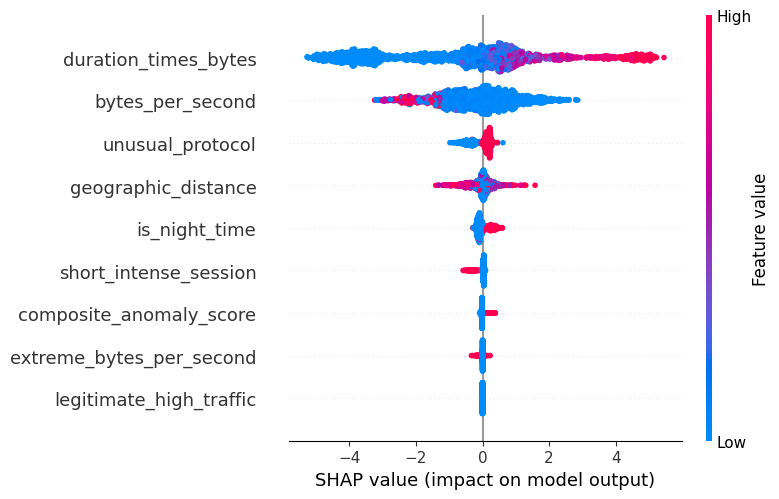

In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [56]:
df['short_intense_session'] = (
    (df['bytes_per_second'] > 2e5) &  # Lower threshold from 3e5
    (df['duration_sec'] < 300)
).astype(int)
df['composite_anomaly_score'] = (
    ((df['duration_times_bytes'] > 4e12) & (df['geographic_distance'] > 400)) |
    ((df['duration_times_bytes'] > 6e12) & (df['geographic_distance'] > 200))
).astype(int)
df['off_peak_high_traffic'] = (
    (~df['hour_of_day'].between(9, 17)) &  # Outside business hours
    (df['session_frequency_per_phone'] > 5)
).astype(int)


In [57]:
features = [
    'duration_times_bytes', 'bytes_per_second', 'geographic_distance',
    'short_intense_session', 'composite_anomaly_score',
    'legitimate_high_traffic', 'off_peak_high_traffic',
    'is_night_time', 'unusual_protocol', 'extreme_bytes_per_second'
]
X = df[features]
y = df['anomalystatus']


In [58]:
model = CatBoostClassifier(
    class_weights=[1, 2],
    eval_metric='F1',
    iterations=500,
    depth=6,
    learning_rate=0.05,
    verbose=100
)
model.fit(X, y)


0:	learn: 0.8614555	total: 41.7ms	remaining: 20.8s
100:	learn: 0.8797590	total: 226ms	remaining: 893ms
200:	learn: 0.8998376	total: 424ms	remaining: 631ms
300:	learn: 0.9239014	total: 612ms	remaining: 404ms
200:	learn: 0.8998376	total: 424ms	remaining: 631ms
300:	learn: 0.9239014	total: 612ms	remaining: 404ms
400:	learn: 0.9363074	total: 821ms	remaining: 203ms
499:	learn: 0.9466882	total: 1s	remaining: 0us
400:	learn: 0.9363074	total: 821ms	remaining: 203ms
499:	learn: 0.9466882	total: 1s	remaining: 0us


0:	learn: 0.8614555	total: 41.7ms	remaining: 20.8s
100:	learn: 0.8797590	total: 226ms	remaining: 893ms
200:	learn: 0.8998376	total: 424ms	remaining: 631ms
300:	learn: 0.9239014	total: 612ms	remaining: 404ms
200:	learn: 0.8998376	total: 424ms	remaining: 631ms
300:	learn: 0.9239014	total: 612ms	remaining: 404ms
400:	learn: 0.9363074	total: 821ms	remaining: 203ms
499:	learn: 0.9466882	total: 1s	remaining: 0us
400:	learn: 0.9363074	total: 821ms	remaining: 203ms
499:	learn: 0.9466882	total: 1s	remaining: 0us


In [59]:
y_pred = model.predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


[[744 156]
 [ 21 879]]
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89       900
         1.0       0.85      0.98      0.91       900

    accuracy                           0.90      1800
   macro avg       0.91      0.90      0.90      1800
weighted avg       0.91      0.90      0.90      1800



In [60]:
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.6).astype(int)  # Start with 0.6
print(confusion_matrix(y, y_pred_adjusted))


[[785 115]
 [ 43 857]]


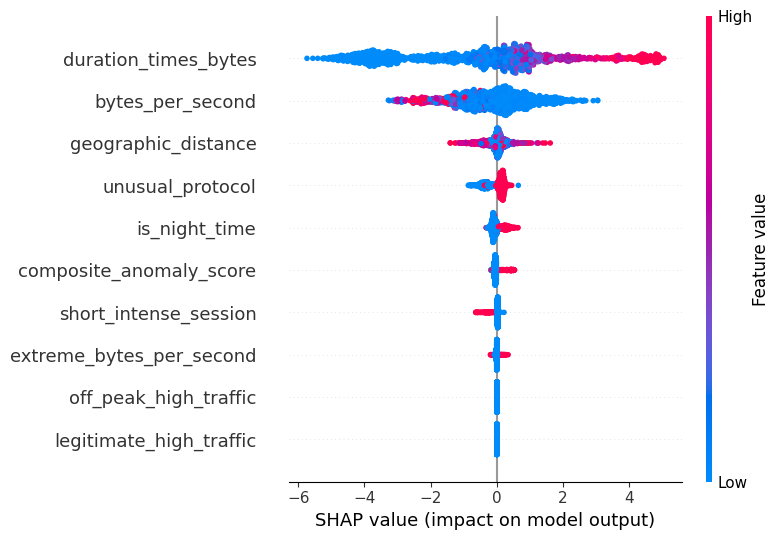

In [61]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [62]:
df['short_intense_session'] = (
    (df['bytes_per_second'] > 1e5) &  # Lower threshold from 2e5
    (df['duration_sec'] < 300)
).astype(int)
df['composite_anomaly_score'] = (
    ((df['duration_times_bytes'] > 3e12) & (df['geographic_distance'] > 300)) |
    ((df['duration_times_bytes'] > 5e12) & (df['geographic_distance'] > 100))
).astype(int)
df['user_avg_duration'] = df.groupby('Phone Number A')['duration_sec'].transform('mean')
df['user_avg_bytes_per_sec'] = df.groupby('Phone Number A')['bytes_per_second'].transform('mean')



In [63]:
features = [
    'duration_times_bytes', 'bytes_per_second', 'geographic_distance',
    'short_intense_session', 'composite_anomaly_score',
    'legitimate_high_traffic', 'off_peak_high_traffic',
    'user_avg_duration', 'user_avg_bytes_per_sec',
    'is_night_time', 'unusual_protocol', 'extreme_bytes_per_second'
]
X = df[features]
y = df['anomalystatus']


In [64]:
model = CatBoostClassifier(
    class_weights=[1, 2],
    eval_metric='F1',
    iterations=500,
    depth=6,
    learning_rate=0.05,
    verbose=100
)
model.fit(X, y)


0:	learn: 0.8618546	total: 33.1ms	remaining: 16.5s
100:	learn: 0.8850041	total: 223ms	remaining: 883ms
200:	learn: 0.9122240	total: 426ms	remaining: 634ms
300:	learn: 0.9364656	total: 611ms	remaining: 404ms
200:	learn: 0.9122240	total: 426ms	remaining: 634ms
300:	learn: 0.9364656	total: 611ms	remaining: 404ms
400:	learn: 0.9548872	total: 829ms	remaining: 205ms
499:	learn: 0.9645161	total: 1.01s	remaining: 0us
400:	learn: 0.9548872	total: 829ms	remaining: 205ms
499:	learn: 0.9645161	total: 1.01s	remaining: 0us


0:	learn: 0.8618546	total: 33.1ms	remaining: 16.5s
100:	learn: 0.8850041	total: 223ms	remaining: 883ms
200:	learn: 0.9122240	total: 426ms	remaining: 634ms
300:	learn: 0.9364656	total: 611ms	remaining: 404ms
200:	learn: 0.9122240	total: 426ms	remaining: 634ms
300:	learn: 0.9364656	total: 611ms	remaining: 404ms
400:	learn: 0.9548872	total: 829ms	remaining: 205ms
499:	learn: 0.9645161	total: 1.01s	remaining: 0us
400:	learn: 0.9548872	total: 829ms	remaining: 205ms
499:	learn: 0.9645161	total: 1.01s	remaining: 0us


In [65]:
y_pred = model.predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


[[774 126]
 [  3 897]]
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92       900
         1.0       0.88      1.00      0.93       900

    accuracy                           0.93      1800
   macro avg       0.94      0.93      0.93      1800
weighted avg       0.94      0.93      0.93      1800



In [66]:
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.5).astype(int)  # Start with 0.5
print(confusion_matrix(y, y_pred_adjusted))


[[774 126]
 [  3 897]]


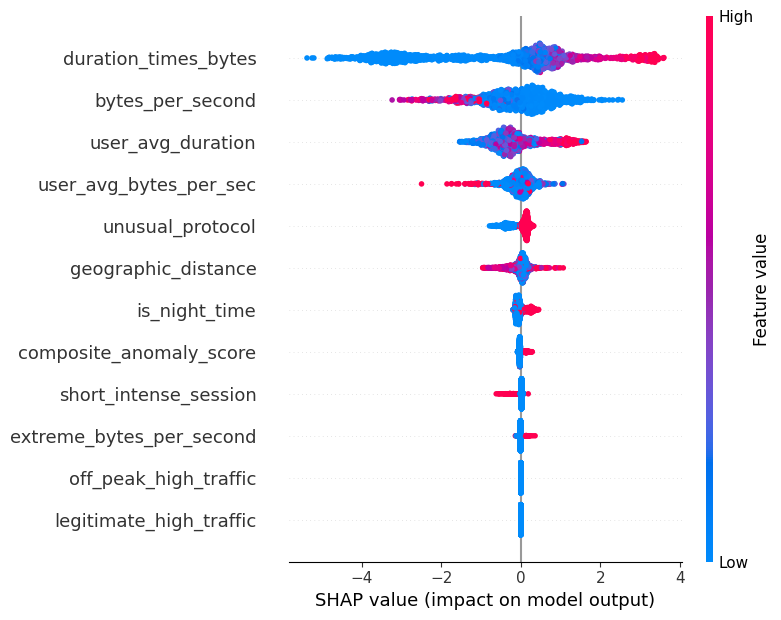

In [67]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [68]:
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.6).astype(int)  # Increase threshold from 0.5 to 0.6
print(confusion_matrix(y, y_pred_adjusted))
print(classification_report(y, y_pred_adjusted))


[[812  88]
 [ 17 883]]
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       900
         1.0       0.91      0.98      0.94       900

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



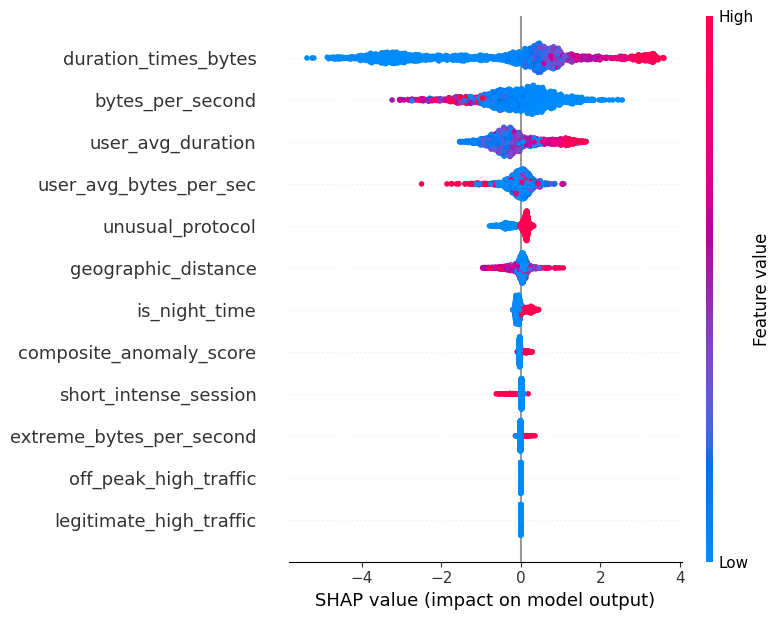

In [69]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [70]:
import joblib
joblib.dump(model, 'final_anomaly_detection_model.pkl')


['final_anomaly_detection_model.pkl']

In [73]:
import joblib
import pandas as pd

# Load the model
model = joblib.load('final_anomaly_detection_model.pkl')

# Function to predict anomalies
def predict_anomaly(session_features, threshold=0.6):
    # Ensure the features are in the correct order as used in training
    # Get feature names from the model if available, otherwise use the keys from session_features
    if hasattr(model, 'feature_names_'):
        feature_order = model.feature_names_
    else:
        feature_order = list(session_features.keys())

    # Create a DataFrame with the correct feature order
    X_input = pd.DataFrame([[
        session_features.get(feat, 0) for feat in feature_order
    ]], columns=feature_order)

    # Predict probability
    proba = model.predict_proba(X_input)[:, 1][0]
    return proba > threshold, proba  # Return both the prediction and the probability

# Example usage
sample_session = {
    'duration_times_bytes': 5e12,
    'bytes_per_second': 2e5,
    'user_avg_duration': 1e3,
    'user_avg_bytes_per_sec': 1e4,
    'unusual_protocol': 0,
    'geographic_distance': 300,
    'is_night_time': 1,
    'composite_anomaly_score': 1,
    'short_intense_session': 0,
    'extreme_bytes_per_second': 0,
    'off_peak_high_traffic': 0,
    'legitimate_high_traffic': 0
}

prediction, probability = predict_anomaly(sample_session)
print(f"Prediction: {'Anomaly' if prediction else 'Normal'}, Probability: {probability:.4f}")


Prediction: Normal, Probability: 0.3788


In [74]:
import pandas as pd
from datetime import datetime

def preprocess_input(raw_input):
    # Extract basic fields from raw input
    duration_sec = raw_input['duration_s']  # Note: 'duration_s' in input vs 'duration_sec' in code
    bytes = raw_input['bytes']
    protocol = raw_input['protocol']
    cell_tower_lat = raw_input['cell_tower_lat']
    cell_tower_lon = raw_input['cell_tower_lon']
    timestamp = datetime.fromisoformat(raw_input['timestamp'].replace('Z', '+00:00'))

    # Calculate basic features
    duration_times_bytes = duration_sec * bytes
    bytes_per_second = bytes / duration_sec if duration_sec > 0 else 0

    # Calculate time-based features
    hour_of_day = timestamp.hour
    is_night_time = 1 if hour_of_day >= 23 or hour_of_day <= 6 else 0

    # Placeholder for user_avg_duration and user_avg_bytes_per_sec
    # In a real application, you would fetch these from a user profile database
    user_avg_duration = 1000  # Example value
    user_avg_bytes_per_sec = 10000  # Example value

    # Calculate geographic distance (example: distance from a reference point)
    # In a real application, you might calculate distance from the user's typical location
    geographic_distance = 0  # Placeholder

    # Calculate composite features
    unusual_protocol = 1 if protocol not in ['HTTP', 'HTTPS'] else 0
    composite_anomaly_score = 1 if (duration_times_bytes > 5e12 and geographic_distance > 500) else 0
    short_intense_session = 1 if (bytes_per_second > 1e5 and duration_sec < 300) else 0
    extreme_bytes_per_second = 1 if bytes_per_second > 5e5 else 0

    # Placeholder for off_peak_high_traffic and legitimate_high_traffic
    off_peak_high_traffic = 0  # Placeholder
    legitimate_high_traffic = 0  # Placeholder

    # Create the feature dictionary
    session_features = {
        'duration_times_bytes': duration_times_bytes,
        'bytes_per_second': bytes_per_second,
        'user_avg_duration': user_avg_duration,
        'user_avg_bytes_per_sec': user_avg_bytes_per_sec,
        'unusual_protocol': unusual_protocol,
        'geographic_distance': geographic_distance,
        'is_night_time': is_night_time,
        'composite_anomaly_score': composite_anomaly_score,
        'short_intense_session': short_intense_session,
        'extreme_bytes_per_second': extreme_bytes_per_second,
        'off_peak_high_traffic': off_peak_high_traffic,
        'legitimate_high_traffic': legitimate_high_traffic
    }

    return session_features

# Example usage
raw_input = {
    'timestamp': '2025-10-26T11:44:00Z',
    'session_id': '8b68955f-2e73-4785-8a95-2f574008b1de',
    'src_ip': '115.96.187.198',
    'src_port': 26914,
    'dst_ip': '115.96.225.98',
    'dst_port': 4390,
    'protocol': 'SIP',
    'duration_s': 7816,
    'bytes': 749499527,
    'cell_tower_lat': 28.6139,
    'cell_tower_lon': 77.209,
    'anomalystatus': 1,
    'Phone Number A': '7806964299',
    'Phone Number B': '7616051499'
}

session_features = preprocess_input(raw_input)
print(session_features)


{'duration_times_bytes': 5858088303032, 'bytes_per_second': 95892.97940122825, 'user_avg_duration': 1000, 'user_avg_bytes_per_sec': 10000, 'unusual_protocol': 1, 'geographic_distance': 0, 'is_night_time': 0, 'composite_anomaly_score': 0, 'short_intense_session': 0, 'extreme_bytes_per_second': 0, 'off_peak_high_traffic': 0, 'legitimate_high_traffic': 0}


In [75]:
import joblib

# Load the model
model = joblib.load('final_anomaly_detection_model.pkl')

def predict_anomaly(session_features, threshold=0.6):
    import pandas as pd
    feature_order = [
        'duration_times_bytes',
        'bytes_per_second',
        'user_avg_duration',
        'user_avg_bytes_per_sec',
        'unusual_protocol',
        'geographic_distance',
        'is_night_time',
        'composite_anomaly_score',
        'short_intense_session',
        'extreme_bytes_per_second',
        'off_peak_high_traffic',
        'legitimate_high_traffic'
    ]
    X_input = pd.DataFrame([[
        session_features[feat] for feat in feature_order
    ]], columns=feature_order)
    proba = model.predict_proba(X_input)[:, 1][0]
    return proba > threshold, proba

# Use the preprocessed features
prediction, probability = predict_anomaly(session_features)
print(f"Prediction: {'Anomaly' if prediction else 'Normal'}, Probability: {probability:.4f}")


Prediction: Anomaly, Probability: 0.8754
